In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def sharpen_image(img):
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0],
    ])
    return cv2.filter2D(img, -1, kernel)

In [3]:
# file = "data/some_top.png"
file = "data/empty_top.png"
# file = "data/people_top.png"
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sharp = sharpen_image(img)
bw = cv2.cvtColor(sharp, cv2.COLOR_RGB2GRAY)

(-0.5, 585.5, 1029.5, -0.5)

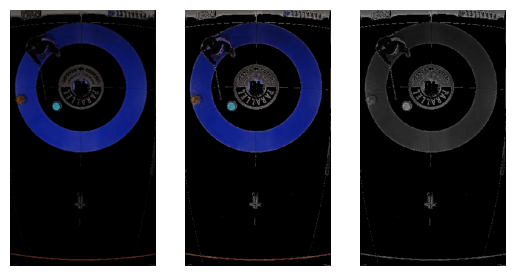

In [4]:
plt.subplot(131)
plt.imshow(img); plt.axis("off")

plt.subplot(132)
sharp = sharpen_image(img)
plt.imshow(sharp); plt.axis("off")

plt.subplot(133)
plt.imshow(bw, cmap = "gray"); plt.axis("off")

(-0.5, 585.5, 1029.5, -0.5)

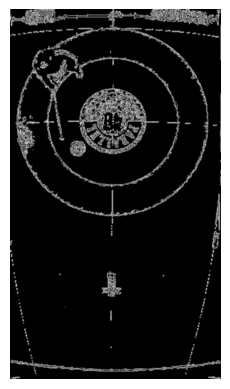

In [5]:
canny = cv2.Canny(bw, 100, 200)
canny = cv2.GaussianBlur(canny, ksize = (5,5), sigmaX = 1)
plt.imshow(canny, cmap = "gray"); plt.axis("off")

(-0.5, 585.5, 1029.5, -0.5)

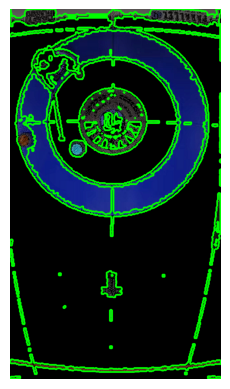

In [6]:
color_canny = np.dstack([canny for _ in range(3)])

contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)); plt.axis('off')

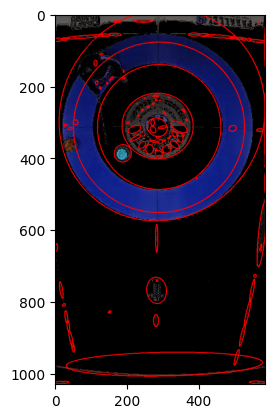

In [7]:
ellipse_img = img.copy()

axes = np.empty((len(contours), 2))
centers = np.empty_like(axes)

for n, contour in enumerate(contours):

    if len(contour) > 5:
        ellipse = cv2.fitEllipse(contour)
        centers[n], axes[n], _ = ellipse
        cv2.ellipse(ellipse_img, ellipse, (255, 0, 0), 2)
plt.imshow(ellipse_img)

In [8]:
circle_img = img.copy()

mask = np.all(axes > 1, axis = 1)
axes = axes[mask]
centers = centers[mask]
ratio = np.max(axes, axis = 1) / np.min(axes, axis = 1)

mask = ratio < 1.2
axes = axes[mask]
centers = centers[mask].astype(np.int32)

diameters = axes.mean(axis = 1)
mask = np.logical_and(diameters > 70, diameters < 1e5)

centers = centers[mask]
diameters = diameters[mask]
print(axes)

[[  7.5387888    8.25832939]
 [561.46716309 600.19030762]
 [  3.1622777    3.1622777 ]
 [  3.1622777    3.1622777 ]
 [342.60964966 347.91653442]
 [ 47.21990204  48.65401077]
 [183.73092651 197.86462402]
 [ 21.00618935  23.78030396]
 [  3.1622777    3.1622777 ]
 [ 49.6048317   57.05162811]
 [  3.65423775   4.25881243]
 [  5.32674313   6.10087967]
 [  5.83095169   5.83095169]
 [474.71954346 475.34457397]
 [ 12.57338905  14.6962204 ]
 [  3.1622777    3.1622777 ]]


Center: [296 280], Diam: 580.8287353515625
Center: [288 313], Diam: 345.2630920410156
Center: [284 311], Diam: 190.7977752685547
Center: [288 314], Diam: 475.0320587158203


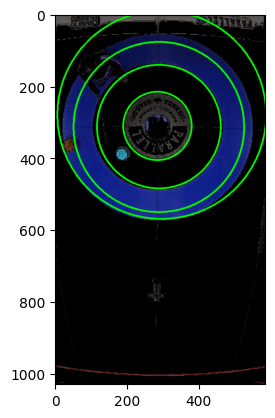

In [9]:
for diam, center in zip(diameters, centers):
    print(f"Center: {center}, Diam: {diam}")
    cv2.circle(
        circle_img,
        center,
        radius= int(diam / 2),
        color = (0, 255, 0),
        thickness = 4
    )

plt.imshow(circle_img)

In [10]:
std = centers.std(axis = 0)
means = centers.mean(axis = 0)
print(centers)

if np.any(std > 10):

    print(f"Std range filtering")
    std_range = std * np.array([
        [-0.75],
        [ 0.75]
    ]) + means
    print(std_range)

    lower_bound = np.all(centers > std_range[0], axis = 1)
    upper_bound = np.all(centers < std_range[1], axis = 1)
    mask = np.logical_and(lower_bound, upper_bound)

    centers = centers[mask]
    diameters = diameters[mask]

print(centers)
# print(means + std_range)

[[296 280]
 [288 313]
 [284 311]
 [288 314]]
Std range filtering
[[285.73082579 293.86030428]
 [292.26917421 315.13969572]]
[[288 313]
 [288 314]]


In [11]:
means

array([289. , 304.5])

Center: [288 313], Diam: 345.2630920410156
Center: [288 314], Diam: 475.0320587158203


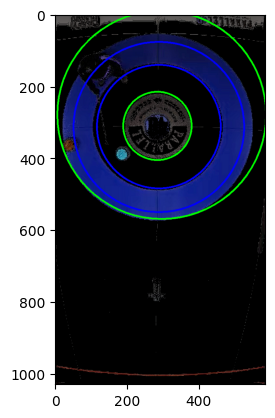

In [12]:
for diam, center in zip(diameters, centers):
    print(f"Center: {center}, Diam: {diam}")
    cv2.circle(
        circle_img,
        center,
        radius=int(diam / 2),
        color=(0, 0, 255),
        thickness=4
    )
plt.imshow(circle_img)

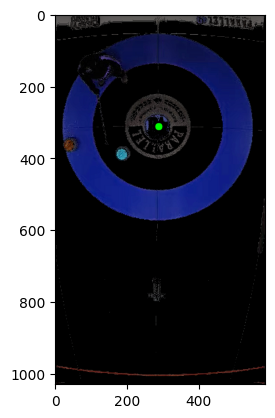

In [13]:
estimated_center = centers.mean(axis = 0).astype(np.int64)

center_img = img.copy()
cv2.circle(center_img, estimated_center, radius = 10, color = (0, 255, 0), thickness = -1)
plt.imshow(center_img)